# Iterative Solvers 3 - The Conjugate Gradient Method

## Symmetric positive definite matrices

A very frequent type of matrices are symmetric positive definite matrices. Let $A\in\mathbb{R}^{n\times n}$ be a symmetric matrix (that is $A^T=A$). $A$ is called symmetric positive definite if 

$$
x^TAx > 0, \forall x\neq 0.
$$

This is equivalent to the condition that all eigenvalues of $A$ are larger than zero (remember that symmetric matrices only have real eigenvalues).

One application of symmetric positive definite matrices are energy functionals. The expression $x^TAx$ arises when discretising functional involving kinetic energies (e.g. energies of the from $E = \frac{1}{2}m|\nabla f|^2$ for f a given function).

For linear systems involving symmetric positive definite matrices we can derive a special algorithm, namely the Method of Conjugate Gradients (CG).

## Lanczos - Arnoldi for symmetric matrices

Let us start with the Arnoldi recurrence relation

$$
AV_m = V_mH_m + h_{m+1,m}v_{m+1}e_m^T
$$

We know that $H_m$ is an upper Hessenberg matrix (i.e. the upper triangular part plus the first lower triangular diagonal can only be nonzero). Also, we know from the orthogonality of the $v_k$ vectors that

$$
V_m^TAV_m = H_m.
$$

Let $A$ now be symmetric. From the symmetry of $A$ an even nicer structure for $H_m$ arises. $H_m$ is upper Hessenberg, but now it is also symmetric. The only possible type of matrices to satisfy this condition are tridional matrices. These are matrices, where only the diagonal and the first upper and lower super/subdiagonals are nonzero.

Let us test this out. Below you find our simple implementation of Arnoldi's method. We then plot the resulting matrix $H_m$.

In [32]:
import numpy as np

def arnoldi(A, r0, m):
    """Perform m-1 step of the Arnoldi method."""
    n = A.shape[0]
    
    V = np.empty((n, m + 1), dtype=np.float64)
    H = np.zeros((m+1, m), dtype=np.float64)
    
    V[:, 0] = r0 / np.linalg.norm(r0)
    
    for index in range(m):
        # Multiply the previous vector with A
        tmp = A @ V[:, index]
        # Now orthogonalise against the previous basis vectors
        h = V[:, :index + 1].T @ tmp # h contains all inner products against previous vectors
        H[:index + 1, index] = h
        w = tmp - V[:, :index + 1] @ h # Subtract the components in the directions of the previous vectors
        # Normalise and store
        H[index + 1, index] = np.linalg.norm(w)
        V[:, index + 1] = w[:] / H[index + 1, index]
                
    return V, H

The following code creates a random symmetric positive definite matrix.

In [33]:
from numpy.random import RandomState

n = 500

rand = RandomState(0)
Q, _ = np.linalg.qr(rand.randn(n, n))
D = np.diag(rand.rand(n))
A = Q.T @ D @ Q

Now let's run Arnoldi's method and plot the matrix H. We are adding some artificial noise so as to ensure for the log-plot that all values are nonzero. The colorscale shows the logarithm of the magnitude of the entries.

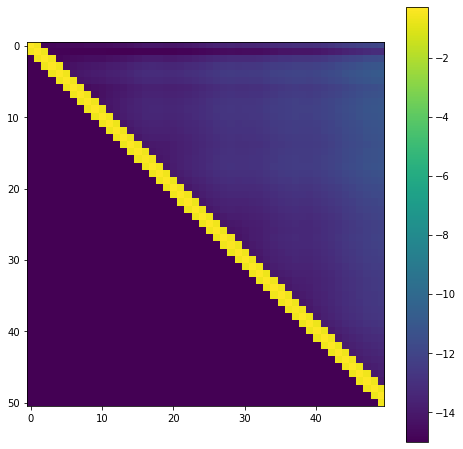

In [42]:
%matplotlib inline
from matplotlib import pyplot as plt

m = 50
r0 = rand.randn(n)
V, H = arnoldi(A, r0, m)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

im = ax.imshow(np.log10(1E-15 + np.abs(H)))
fig.colorbar(im)

It is clearly visible that only the main diagonal and the first upper and lower off-diagonal are nonzero, as expected. This hugely simplifies the Arnoldi iteration. Instead of orthogonalising $Av_m$ against all previous vectors we only need to orthogonalise against $v_m$ and $v_{m-1}$. All other inner products are already zero. Hence, the main orthogonalisation step now takes the form

$$
w = Av_m - (v_m^TAv_m)v_m - (v_{m-1}^TAv_m)v_{m-1}.
$$

Since the new vector $w$ is composed of only 3 vectors. This is also called a 3-term recurrence. The big advantage is that in addition to $Av_m$ we only need to keep $v_m$ and $v_{m-1}$ in memory. Hence, no matter how many iterations we do, the memory requirement remains constant, in contrast to Arnoldi for nonsymmetric matrices, where we need to keep all previous vectors in memory.

Arnoldi with a short recurrence relation for symmetric matrices has a special name. It is called **Lanczos method**.

## Solving linear systems of equations with Lanczos

We can now proceed exactly as in the Full orthogonalisation method and arrive at the linear system of equations

$$
T_my_m = \|r_0\|_2e_1,
$$

where $x_m = x_0 + V_my_m$ and $T_m = V_m^TAV_m$ is the tridiagonal matrix obtained from the Lanczos method.

The conjugate gradient method is an implementation of this approach. A very good derivation from Lanczos to CG is obtained in the beautiful book by Yousef Saad "[Iterative Methods for Sparse Linear Systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf)", which is available online for free. Here, we will briefly motivate another approach to CG, which is a bit more intuitive and reveals more about the structure of the method, namely CG as an optimisation algorithm for a quadratic minimisation problem. One of the most beautiful summaries of this approach is contained in the paper [An introduction to the Conjugate Gradient Method Without the Agonizing Pain](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) by Jonathan Shewchuk.

## A quadratic optimisation problem

We consider the quadratic minimisation problem

$$
\min_{x\in\mathbb{R}^n} f(x)
$$

with $f(x)=\frac{1}{2}x^TAx - b^Tx$. We have

$$
\nabla f(x) = Ax - b
$$

and hence the only stationary point is the solution of the linear system $Ax=b$. Furthermore, it is really a minimiser since $f''(x) > 0$ for all $x\in\mathbb{R}^n$ as $A$ is positive definite.

## The Method of Steepest Descent

Our first idea is the method of steepest descent. Remember that the negative gradient is a descent direction. Given a point $x_k$. We have

$$
-\nabla f(x_k) = b - Ax_k := r_k.
$$

The negative gradient is hence just the residual. Hence, we need to minimise along the direction of the residual, that is we will have
$x_{k+1} = x_k + \alpha_k r_k$ for some value $\alpha_k$. To compute $\alpha_k$ we just solve

$$
\frac{d}{d\alpha}f(x_k + \alpha r_k) = 0
$$

Since $\frac{d}{d\alpha}f(x_k + \alpha r_k) = r_{k+1}^Tr_k$ we just need to choose $\alpha_k$ such that $r_{k+1}$ is orthogonal to $r_k$. The solution is given by $\alpha_k = \frac{r_k^Tr_k}{r_k^TAr_k}$. This gives us a complete method consisting of three steps to get from $x_k$ to $x_{k+1}$.

$$
\begin{align}
r_k &= b - Ax_k\nonumber\\
\alpha_k &= \frac{r_k^Tr_k}{r_k^TAr_k}\nonumber\\
x_{k+1} &= x_k + \alpha_k r_k
\end{align}
$$

We are not going to derive the complete convergence analysis here but only state the final result. Let $\kappa := \frac{\lambda_{max}}{\lambda_{min}}$, where $\lambda_{max}$ and $\lambda_{min}$ are the largest, respectively smallest eigenvalue of $A$ (remember that all eigenvalues are positive since $A$ is symmetric positive definite). The number $\kappa$ is called the condition number of $A$. Let $e_k = x_k - x^*$ be the difference of the exact solution $x^*$ satisfying $Ax^*=b$ and our current iterate $x_k$. Note that $r_k = -Ae_k$.

We now have that

$$
\|e_k\|_A\leq \left(\frac{\kappa - 1}{\kappa + 1}\right)^k\|e_0\|_A,
$$

where $\|e_k\|_A := \left(e_k^TAe_k\right)^{1/2}$.

This is an extremely slow rate of convergence. Let $\kappa=10$, which is a fairly small number. Then the error reduces in each step only by a factor of $\frac{9}{11}\approx 0.81$ and we need 11 iterations for each digit of accuracy.

## The method of conjugate directions

The steepest descent approach was not bad. But we want to improve on it. The problem with the steepest descent method is that we have no guarantee that we are reducing the error $e_{k+1}$ as much as possible along our current direction $r_k$ when we minimize. But we can fix this.

Let us pick a set of directions $d_0, d_1, \dots, d_{n-1}$, which are mutually orthogonal, that is $d_i^Td_j =0$ for $i\neq j$. We now want to enforce the condition that

$$
e_{k+1}^Td_k = 0.
$$

This means that the remaining error is orthogonal to $d_k$ and hence is a linear combination of all the other search directions. We have therefore exhausted all the information from $d_k$. Let's play this through.

We know that $e_{k+1} = x_{k+1} - x^* = x_k -x^* + \alpha_k d_k = e_k + \alpha_kd_k$.

It follows that

$$
\begin{align}
e_{k+1}^Td_k &= d_k^T(e_k + \alpha_kd_k)\nonumber\\
             &= d_k^Te_k + \alpha_kd_k^Td_k = 0\nonumber
\end{align}
$$

and therefore $\alpha_k = -\frac{d_k^Te_k}{d_k^Td_k}$.

Unfortunately, this does not quite work in practice as we don't know $e_k$. But there is a solution. Remember that $r_k = -Ae_k$. We just need an $A$ in the right place. To achieve this we choose **conjugate directions**, that is we impose the condition that

$$
d_i^TAd_j = 0
$$

for $i\neq j$. We also impose the condition that $e_{k+1}^TAd_k = 0$. Writing this out we obtain

$$
\alpha_k = \frac{d_k^Tr_k}{d_k^TAd_k}.
$$

This expression is computable if we have a suitable set of conjugate directions $d_k$. Moreoever, it guarantees that the method converges in at most $n$ steps since in every iteration we are annihiliating the error in the direction of $d_k$ and there are only $n$ different directions.

## Conjugate Gradients - Mixing steepest descent with conjugate directions

The idea of conjugate gradients is to obtain the conjugate directions $d_i$ by taking the $r_i$ (the gradients) and to $A$-orthogonalise (conjugate) them against the previous directions. We are leaving out the details of the derivation and refer to the Shewchuk paper. But the final algorithm now takes the following form.

$$
\begin{align}
d_0 &= r_0 = b - Ax_0\nonumber\\
\alpha_i &= \frac{r_i^Tr_i}{d_i^TAd_i}\nonumber\\
x_{i+1} &=x_i + \alpha_id_i\nonumber\\
r_{i+1} &= r_i - \alpha_i Ad_i\nonumber\\
\beta_{i+1} &= \frac{r_{i+1}^Tr_{i+1}}{r_i^Tr_i}\nonumber\\
d_{i+1} &= r_{i+1} + \beta_{i+1}d_i\nonumber
\end{align}
$$

Conjugate Gradients has a much more favourable convergence bound than steepest descent. One can derive that

$$
\|e_i\|_A\leq 2\left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)^i\|e_0\|_A.
$$

If we choose again the example that $\kappa=10$ we obtain

$$
\|e_i\|A\lessapprox 0.52^i\|e_0\|_A.
$$

Hence, we need around $4$ iterations for each digits of accuracy instead of 11 for the method of steepest descent.

## A numerical example

The following code creates a symmetric positive definite matrix.

In [69]:
from scipy.sparse import diags

n = 10000

data = [2.1 * np.ones(n),
        -1. * np.ones(n - 1),
        -1. * np.ones(n - 1)]

offsets = [0, 1, -1]

A = diags(data, offsets=offsets, shape=(n, n), format='csr')

We now solve the associated linear system with CG and plot the convergence.

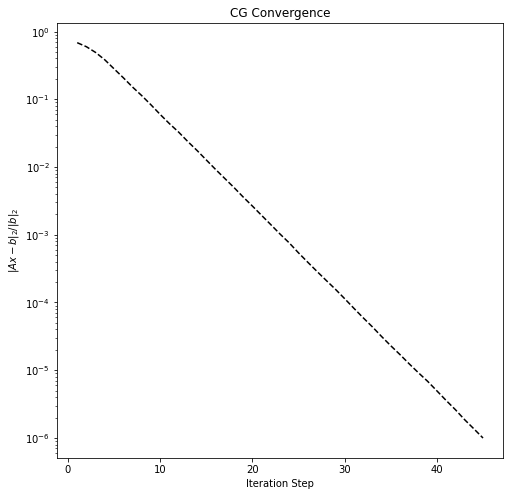

In [73]:
from scipy.sparse.linalg import cg

b = rand.randn(n)
residuals = []

callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

sol, _ = cg(A, b, tol=1E-6, callback=callback, maxiter=1000)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(1 + np.arange(len(residuals)), residuals, 'k--')
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-b\|_2 / \|b\|_2$')